In [1]:
import os

# for data analytics
import pandas as pd
import numpy as np
from collections import Counter

# for visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import talib 
import pandas_ta as ta

# for data preparation
from sklearn.preprocessing import RobustScaler,MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score

# # hyperopt - used for Bayesian hyperparameter tuning
# from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
# from hyperopt.pyll import scope

# for timing
from time import time
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

2023-03-30 19:44:09.525221: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
!brew install ta-lib

==> Downloading https://formulae.brew.sh/api/formula.jws.json
##O#-#                                                                        
==> Downloading https://formulae.brew.sh/api/cask.jws.json

To reinstall 0.4.0, run:
  brew reinstall ta-lib


In [3]:
!pip3 install TA-Lib

In [4]:
! pip install pandas-ta

In [5]:
!pip install tensorflow

In [6]:
broker =  pd.read_csv('../quantitative_data_sample.csv').rename(columns={'Date':'date'})
broker['date'] = pd.to_datetime(broker['date']).dt.tz_localize(None)
sentiment =  pd.read_csv('../qualitative_data_sample.csv')
sentiment['date'] = pd.to_datetime(sentiment['date'])

In [7]:
df = pd.merge(broker, sentiment, on='date', how='left')
df.head()

,date,open,high,low,close,volume,priceUsd,is_greater,score
0,2023-03-25,27487.337891,27791.826172,27196.234375,27494.707031,13383005987,27546.328059,0,0.13836
1,2023-03-24,28324.111328,28388.437500,27039.265625,27493.285156,25980310960,28022.257161,1,0.41186
2,2023-03-23,27301.957031,28729.843750,27183.363281,28333.972656,24220433689,27852.398940,0,-0.03958
3,2023-03-22,28158.720703,28803.335938,26759.996094,27307.437500,33382021890,28110.006364,1,0.07636
4,2023-03-21,27768.392578,28439.562500,27439.646484,28175.816406,36102192830,28013.021553,1,-0.06332


In [8]:
df.drop(['priceUsd'], inplace=True, axis=1)

In [9]:
df['next_day_closing_price'] = df['close'].shift(-1)

df.replace(to_replace='null', value=np.nan,inplace=True)
df.drop(df.tail(1).index,inplace=True)
df

,date,open,high,low,close,volume,is_greater,score,next_day_closing_price
0,2023-03-25,27487.337891,27791.826172,27196.234375,27494.707031,13383005987,0,0.13836,27493.285156
1,2023-03-24,28324.111328,28388.437500,27039.265625,27493.285156,25980310960,1,0.41186,28333.972656
2,2023-03-23,27301.957031,28729.843750,27183.363281,28333.972656,24220433689,0,-0.03958,27307.437500
3,2023-03-22,28158.720703,28803.335938,26759.996094,27307.437500,33382021890,1,0.07636,28175.816406
4,2023-03-21,27768.392578,28439.562500,27439.646484,28175.816406,36102192830,1,-0.06332,27767.236328
...,...,...,...,...,...,...,...,...,...
1086,2020-04-01,6437.319336,6612.573730,6202.373535,6606.776367,40346426266,0,0.32036,6438.644531
1087,2020-03-31,6430.606445,6504.515137,6374.162109,6438.644531,32786468812,1,0.12956,6429.841797
1088,2020-03-30,5925.538574,6517.195801,5903.234375,6429.841797,37101651525,1,0.21330,5922.042969
1089,2020-03-29,6245.624512,6250.467285,5920.085938,5922.042969,28373690931,0,NaN,6242.193848


In [10]:
def feature_smoothening(df,feature_name,smoothening_type,smoothening_range=[3,7,21],show_plot=False,show_original_Feature_in_plot=True):
    if smoothening_type == 'sma':
        for j in smoothening_range:
            df[f'{smoothening_type}{j} {feature_name}'] = ta.sma(df[feature_name],j) 

    elif smoothening_type == 'stdev':
        for j in smoothening_range:
            df[f'{smoothening_type}{j} {feature_name}'] = ta.stdev(df[feature_name],j)
    
    elif smoothening_type == 'ema':
        for j in smoothening_range:
            df[f'{smoothening_type}{j} {feature_name}'] = ta.ema(df[feature_name],j)

    elif smoothening_type == 'wma':
        for j in smoothening_range:
            df[f'{smoothening_type}{j} {feature_name}'] = ta.wma(df[feature_name],j)

    elif smoothening_type == 'rsi':
        for j in smoothening_range:
             df[f'{smoothening_type}{j} {feature_name}'] = ta.rsi(df[feature_name],j)

    elif smoothening_type == 'dema':
        for j in smoothening_range:
            df[f'{smoothening_type}{j} {feature_name}'] = ta.dema(df[feature_name],j) 

    elif smoothening_type == 'tema':
        for j in smoothening_range:
            df[f'{smoothening_type}{j} {feature_name}'] = ta.tema(df[feature_name],j) 

    elif smoothening_type == 'macd':
        macd_df = ta.macd(df[feature_name])
        df[f'{smoothening_type} hist {feature_name}'] = macd_df['MACDh_12_26_9']
        df[f'{smoothening_type} signal {feature_name}'] = macd_df['MACDs_12_26_9']
        df[f'{smoothening_type} {feature_name}'] = macd_df['MACD_12_26_9']

    
    # if show_plot == True and show_original_Feature_in_plot==True :
    #     df[[feature_name]+[i for i in list(df.columns) if i.split(" ")[-1] == feature_name and i.split(" ")[0][0:len(smoothening_type)] == smoothening_type]].plot(kind='line',figsize=(25,5))
    #     plt.grid()
    #     plt.title(f'Feature Smoothening-{feature_name} by {smoothening_type}')
    #     plt.xticks([])
    #     plt.show()

    # elif show_plot == True and show_original_Feature_in_plot==False :
    #     df[[i for i in list(df.columns) if i.split(" ")[-1] == feature_name and i.split(" ")[0][0:len(smoothening_type)] == smoothening_type]].plot(kind='line',figsize=(25,5))
    #     plt.grid()
    #     plt.title(f'Feature Smoothening-{feature_name} by {smoothening_type}')
    #     plt.xticks([])
    #     plt.show()

In [11]:
feature_list = [i for i in list(df.columns) if i not in ['date','next_day_closing_price', 'is_greater']]

In [12]:
feature_smoothening(df,'close','macd',show_plot=True,show_original_Feature_in_plot=False)


In [13]:
for feature in feature_list:
    feature_smoothening(df,feature,'sma',show_plot=False)
    feature_smoothening(df,feature,'wma',show_plot=False)
    feature_smoothening(df,feature,'ema',show_plot=False)
    feature_smoothening(df,feature,'dema',show_plot=False)
    feature_smoothening(df,feature,'tema',show_plot=False)
    feature_smoothening(df,feature,'stdev',show_plot=False)
    feature_smoothening(df,feature,'rsi',show_plot=True,show_original_Feature_in_plot=False)
    feature_smoothening(df,feature,'macd',show_plot=True,show_original_Feature_in_plot=False)
    


/var/folders/_2/kqv_6ddx3hj55w49w6kgz4_h0000gn/T/ipykernel_35913/1223164362.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{smoothening_type}{j} {feature_name}'] = ta.sma(df[feature_name],j)
/var/folders/_2/kqv_6ddx3hj55w49w6kgz4_h0000gn/T/ipykernel_35913/1223164362.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{smoothening_type}{j} {feature_name}'] = ta.sma(df[feature_name],j)
/var/folders/_2/kqv_6ddx3hj55w49w6kgz4_h0000gn/T/ipykernel_35913/1223164362.py:16: PerformanceWarning: DataFrame is highly fragmente

In [14]:
df.shape

(1091, 153)

In [15]:
df[df.columns.difference(['score'])] = df[df.columns.difference(['score'])].fillna(method='bfill')
df.loc[:, 'score'] = df['score'].fillna(df['score'].mode(),inplace=False, downcast='infer')
df = df.dropna()

In [16]:
missing_values = pd.DataFrame(df.isna().sum(),columns=['missing_count'])
missing_values.sort_values(by='missing_count',ascending=False)

,missing_count
date,0
sma3 volume,0
tema21 close,0
stdev3 close,0
stdev7 close,0
...,...
stdev7 high,0
stdev21 high,0
rsi3 high,0
rsi7 high,0


In [17]:
df.shape

(1089, 153)

In [18]:

def feature_imp(df,feat_importance,n_select_features):
    feat_imp_df = pd.DataFrame(data = {"Feature Name": df.columns,"Feature Importance":feat_importance})

    feat_imp_df = feat_imp_df.sort_values("Feature Importance",ascending=False)[:n_select_features]

    # fig,ax = plt.subplots(figsize=(14,12))
    # ax = sns.barplot(x = "Feature Importance",y = "Feature Name",
    #                 data=feat_imp_df,palette="nipy_spectral")
    # plt.title('Feature Importances')

    # cmap = plt.get_cmap('nipy_spectral_r',n_select_features)
    # minfi = min(feat_imp_df['Feature Importance'])
    # maxfi = max(feat_imp_df['Feature Importance'])
    # #https://stackoverflow.com/a/43807666
    # norm = mpl.colors.Normalize(vmin=minfi,vmax=maxfi)
    # sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
    # sm.set_array([])
    # # plt.colorbar(sm,ticks=np.linspace(minfi,maxfi,n_select_features),
    # #             boundaries=np.arange(minfi,maxfi+0.001,.0001))
    # ax.xaxis.grid()
    # plt.show()
    return feat_imp_df,df[feat_imp_df['Feature Name']]

In [19]:

X = df.drop(['date','next_day_closing_price'],axis=1)

scaler = RobustScaler()
X_scaled = X.copy()
X_scaled[X.columns] = scaler.fit_transform(X[X.columns])

scaler = MinMaxScaler()
X_scaled[X.columns] =  scaler.fit_transform(X_scaled[X.columns])
X_scaled

,open,high,low,close,volume,is_greater,score,macd hist close,macd signal close,macd close,...,tema21 score,stdev3 score,stdev7 score,stdev21 score,rsi3 score,rsi7 score,rsi21 score,macd hist score,macd signal score,macd score
0,0.349892,0.341772,0.352074,0.344552,0.016513,0.0,0.443667,0.707615,0.321238,0.401462,...,0.319123,0.475996,0.475883,0.355088,0.457059,0.406511,0.711380,0.243534,0.539341,0.414764
1,0.363470,0.351351,0.349478,0.344529,0.053213,1.0,0.692290,0.707615,0.321238,0.401462,...,0.319123,0.475996,0.475883,0.355088,0.457059,0.406511,0.711380,0.243534,0.539341,0.414764
2,0.346884,0.356832,0.351861,0.358280,0.048086,0.0,0.281912,0.707615,0.321238,0.401462,...,0.319123,0.475996,0.475883,0.355088,0.457059,0.406511,0.711380,0.243534,0.539341,0.414764
3,0.360787,0.358012,0.344861,0.341489,0.074776,1.0,0.387306,0.707615,0.321238,0.401462,...,0.319123,0.491117,0.475883,0.355088,0.457059,0.406511,0.711380,0.243534,0.539341,0.414764
4,0.354453,0.352172,0.356098,0.355693,0.082701,1.0,0.260331,0.707615,0.321238,0.401462,...,0.319123,0.148594,0.475883,0.355088,0.334044,0.406511,0.711380,0.243534,0.539341,0.414764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1084,0.014148,0.008007,0.012733,0.004965,0.091075,1.0,0.571296,0.471577,0.439030,0.435023,...,0.380552,0.249190,0.313550,0.047863,0.823276,0.756943,0.703867,0.675880,0.189604,0.472877
1085,0.011055,0.009372,0.011453,0.005950,0.116374,1.0,0.399596,0.469552,0.440388,0.435619,...,0.378910,0.221783,0.310364,0.043073,0.434279,0.484831,0.476464,0.624458,0.234377,0.467962
1086,0.008305,0.001735,0.004946,0.002894,0.095066,0.0,0.609112,0.464623,0.441330,0.434973,...,0.475647,0.251737,0.310715,0.131066,0.744163,0.742133,0.734330,0.738625,0.308341,0.587838
1087,0.008196,0.000000,0.007787,0.000144,0.073041,1.0,0.435667,0.458498,0.441752,0.433509,...,0.473995,0.252569,0.261304,0.133763,0.434322,0.494675,0.510321,0.668430,0.364357,0.577921


In [20]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestRegressor

In [21]:
y = df['next_day_closing_price']
rf = RandomForestRegressor(n_estimators=50,n_jobs=-1,bootstrap=True,
                           verbose=5,random_state=1)
rf.fit(X_scaled,y)
     

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=-1)]: Done  46 out of  50 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.7s finished


RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=1, verbose=5)

In [22]:
feat_range = list(range(3,15,1))

In [23]:
import matplotlib.pyplot as plt
import matplotlib as mpl
for i in feat_range:
    feat_imp_df,df_next_day = feature_imp(X_scaled,rf.feature_importances_,i)
    df_next_day.insert(loc=0, column='date', value=df['date'])
    df_next_day['next_day_closing_price'] = df['next_day_closing_price']

In [24]:
df_next_day.shape

(1089, 16)

In [25]:

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_metrics(y, ypred):
    MAE = metrics.mean_absolute_error(y, ypred)
    RMSE = metrics.mean_squared_error(y, ypred,squared=False)
    return MAE,RMSE

def plot_results(y,ypred,title=None):
    plt.figure(figsize=(25,5))
    plt.plot(y,label='actual')
    plt.plot(ypred,label='predicted')
    plt.legend()
    plt.grid()
    plt.title(title)
    plt.show()

In [26]:
import tensorflow as tf

def init_model():
    model = Sequential()
    model.add(LSTM(units=40, return_sequences=True, input_shape=(X.shape[1],1), activation='relu'))
    model.add(Dropout(0.2)) # To prevent overfitting
    model.add(LSTM(units=40, return_sequences=True,activation='relu'))
    model.add(Dropout(0.2)) # To prevent overfitting
    model.add(LSTM(units=40))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError(),'mae'])
    return model
# history = model.fit(x_train, y_train, epochs=50, batch_size=64)


In [27]:
test_df = df_next_day[df_next_day['date'] >= '2023-01-01'] # need change to more dynamic 
train_df = df_next_day[df_next_day['date'] < '2023-01-01']
print(f'size of train dataset: {len(train_df)}')
print(f'size of test dataset: {len(test_df)}')

X = train_df.drop(['date','next_day_closing_price'],axis=1)
y = train_df['next_day_closing_price'].to_numpy().reshape(-1,1)

X_test = test_df.drop(['date','next_day_closing_price'],axis=1)

X_scaler = MinMaxScaler()
X_scaled =  X_scaler.fit_transform(X)
X_test_scaled = X_scaler.transform(X_test)

y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y)

size of train dataset: 1006
size of test dataset: 83


In [28]:
model = init_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 40)            6720      
                                                                 
 dropout (Dropout)           (None, 14, 40)            0         
                                                                 
 lstm_1 (LSTM)               (None, 14, 40)            12960     
                                                                 
 dropout_1 (Dropout)         (None, 14, 40)            0         
                                                                 
 lstm_2 (LSTM)               (None, 40)                12960     
                                                                 
 dropout_2 (Dropout)         (None, 40)                0         
                                                                 
 dense (Dense)               (None, 1)                 4

2023-03-30 19:44:22.823897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 19:44:22.824911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 19:44:22.826857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [29]:
X.shape

(1006, 14)

In [30]:
# def plot_loss_curve(history): # no validation split
#     loss = history.history['loss']
#     val_loss = history.history['val_loss']
#     epochs = range(len(loss))
#     plt.figure()
#     plt.plot(epochs, loss, 'b', label='Training loss')
#     plt.plot(epochs, val_loss, 'r', label='Validation loss')
#     plt.title("Training and Validation Loss")
#     plt.legend()
#     plt.show()

Epoch 1/80


2023-03-30 19:44:23.466789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 19:44:23.468230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 19:44:23.469956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 4s 27ms/step - loss: 0.0479 - root_mean_squared_error: 0.2188 - mae: 0.2151
Epoch 2/80
3/3 [==============================] - 0s 17ms/step - loss: 0.0304 - root_mean_squared_error: 0.1744 - mae: 0.1698
Epoch 3/80
3/3 [==============================] - 0s 17ms/step - loss: 0.0149 - root_mean_squared_error: 0.1220 - mae: 0.1142
Epoch 4/80
3/3 [==============================] - 0s 52ms/step - loss: 0.0032 - root_mean_squared_error: 0.0563 - mae: 0.0423
Epoch 5/80
3/3 [==============================] - 0s 15ms/step - loss: 0.0049 - root_mean_squared_error: 0.0699 - mae: 0.0594
Epoch 6/80
3/3 [==============================] - 0s 19ms/step - loss: 0.0054 - root_mean_squared_error: 0.0738 - mae: 0.0641
Epoch 7/80
3/3 [==============================] - 0s 20ms/step - loss: 0.0026 - root_mean_squared_error: 0.0507 - mae: 0.0406
Epoch 8/80
3/3 [==============================] - 0s 19ms/step - loss: 0.0017 - root_mean_squared_error: 0.0413 - mae: 0.0330
Epo

2023-03-30 19:44:32.536774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 19:44:32.538047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 19:44:32.539392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 1s 5ms/step
Mean Absolute Percentage Error: 2.8400342446316515
Mean Absolute Error: 0.012873238722371446
Root Mean Squared Error: 0.016883931948418206


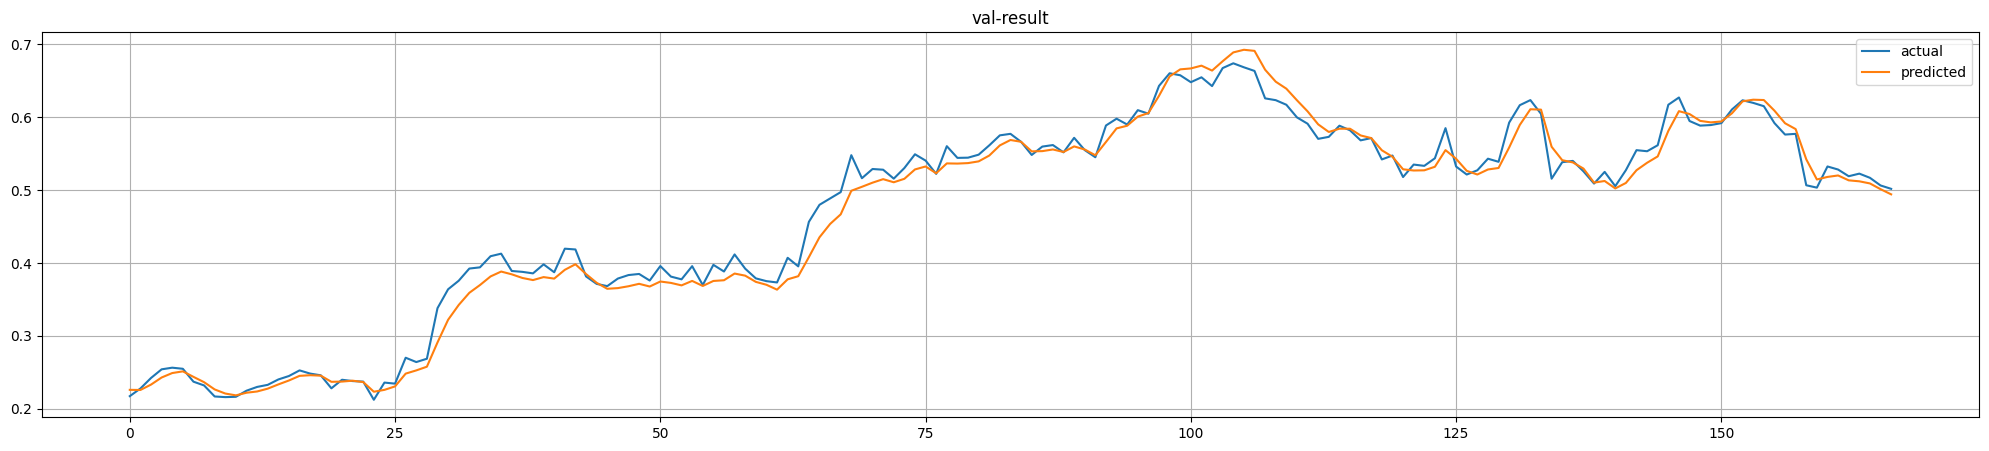

Epoch 1/80


2023-03-30 19:44:33.354882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 19:44:33.356020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 19:44:33.357663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 4s 15ms/step - loss: 0.1219 - root_mean_squared_error: 0.3492 - mae: 0.3108
Epoch 2/80
6/6 [==============================] - 0s 13ms/step - loss: 0.0502 - root_mean_squared_error: 0.2241 - mae: 0.1765
Epoch 3/80
6/6 [==============================] - 0s 13ms/step - loss: 0.0188 - root_mean_squared_error: 0.1372 - mae: 0.1187
Epoch 4/80
6/6 [==============================] - 0s 14ms/step - loss: 0.0173 - root_mean_squared_error: 0.1314 - mae: 0.1137
Epoch 5/80
6/6 [==============================] - 0s 13ms/step - loss: 0.0137 - root_mean_squared_error: 0.1170 - mae: 0.0903
Epoch 6/80
6/6 [==============================] - 0s 13ms/step - loss: 0.0118 - root_mean_squared_error: 0.1085 - mae: 0.0832
Epoch 7/80
6/6 [==============================] - 0s 13ms/step - loss: 0.0083 - root_mean_squared_error: 0.0909 - mae: 0.0792
Epoch 8/80
6/6 [==============================] - 0s 13ms/step - loss: 0.0066 - root_mean_squared_error: 0.0812 - mae: 0.0698
Epo

2023-03-30 19:44:44.478543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 19:44:44.480188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 19:44:44.481541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 1s 5ms/step
Mean Absolute Percentage Error: 4.211511070932652
Mean Absolute Error: 0.03140314039865094
Root Mean Squared Error: 0.036046948898046896


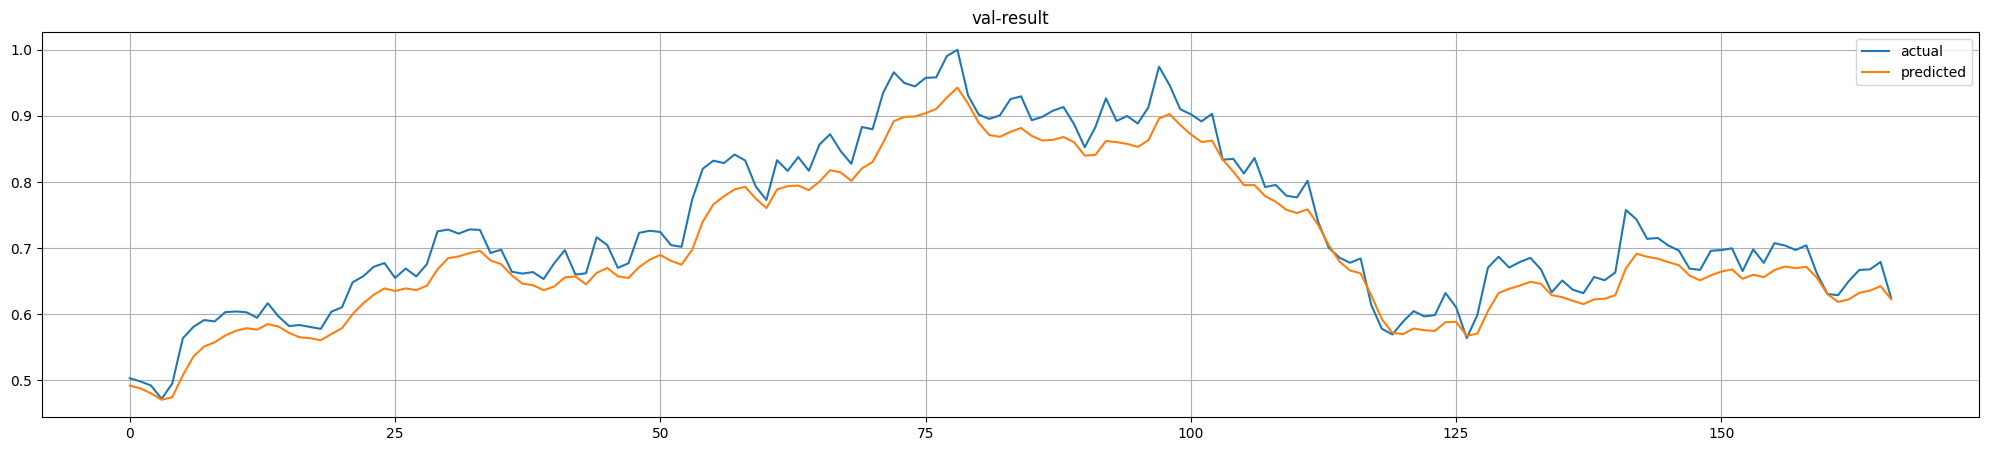

Epoch 1/80


2023-03-30 19:44:45.306720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 19:44:45.307903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 19:44:45.309496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 4s 18ms/step - loss: 0.1826 - root_mean_squared_error: 0.4273 - mae: 0.3672
Epoch 2/80
8/8 [==============================] - 0s 17ms/step - loss: 0.0382 - root_mean_squared_error: 0.1954 - mae: 0.1602
Epoch 3/80
8/8 [==============================] - 0s 18ms/step - loss: 0.0237 - root_mean_squared_error: 0.1540 - mae: 0.1303
Epoch 4/80
8/8 [==============================] - 0s 15ms/step - loss: 0.0181 - root_mean_squared_error: 0.1345 - mae: 0.1086
Epoch 5/80
8/8 [==============================] - 0s 16ms/step - loss: 0.0113 - root_mean_squared_error: 0.1061 - mae: 0.0883
Epoch 6/80
8/8 [==============================] - 0s 15ms/step - loss: 0.0076 - root_mean_squared_error: 0.0871 - mae: 0.0732
Epoch 7/80
8/8 [==============================] - 0s 16ms/step - loss: 0.0064 - root_mean_squared_error: 0.0801 - mae: 0.0633
Epoch 8/80
8/8 [==============================] - 0s 15ms/step - loss: 0.0061 - root_mean_squared_error: 0.0778 - mae: 0.0608
Epo

2023-03-30 19:45:01.112489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 19:45:01.113724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 19:45:01.115078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 1s 5ms/step
Mean Absolute Percentage Error: 6.1142002544773675
Mean Absolute Error: 0.04163513125085238
Root Mean Squared Error: 0.048706584972644705


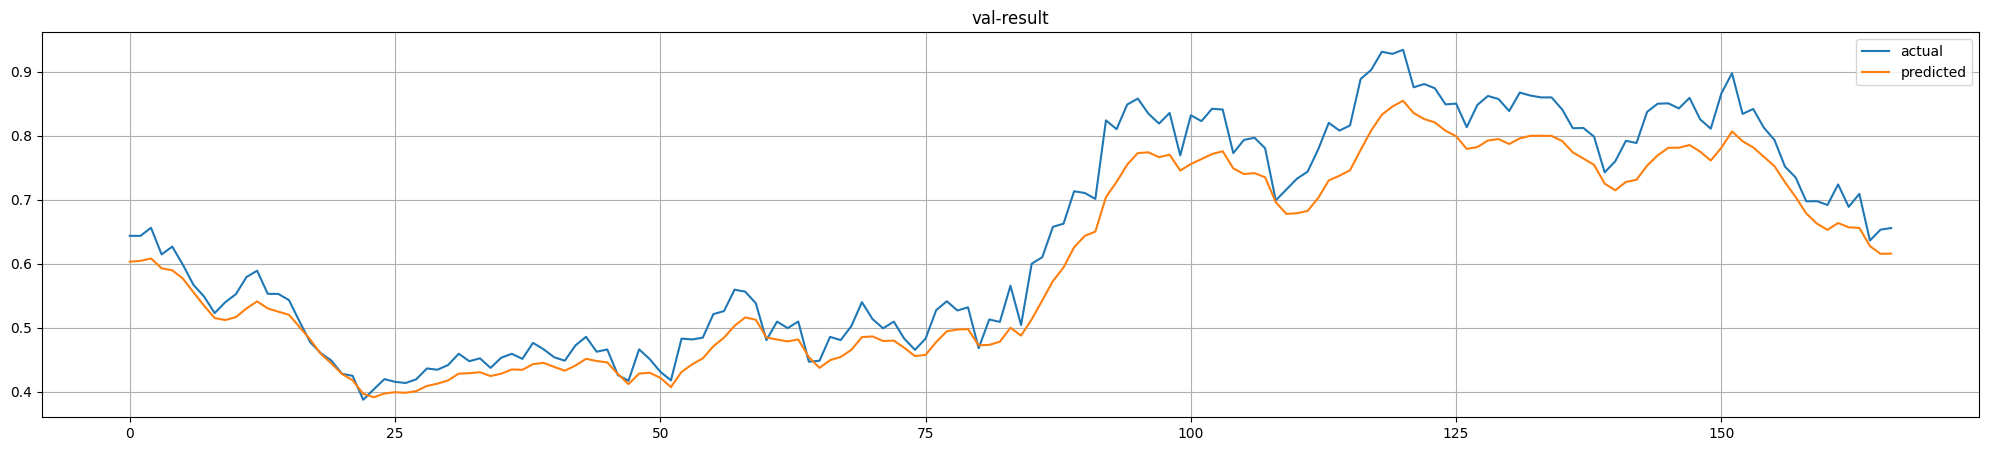

Epoch 1/80


2023-03-30 19:45:01.897187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 19:45:01.898252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 19:45:01.900247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 4s 17ms/step - loss: 0.2330 - root_mean_squared_error: 0.4827 - mae: 0.4257
Epoch 2/80
11/11 [==============================] - 0s 14ms/step - loss: 0.0457 - root_mean_squared_error: 0.2138 - mae: 0.1790
Epoch 3/80
11/11 [==============================] - 0s 14ms/step - loss: 0.0203 - root_mean_squared_error: 0.1426 - mae: 0.1180
Epoch 4/80
11/11 [==============================] - 0s 13ms/step - loss: 0.0142 - root_mean_squared_error: 0.1192 - mae: 0.0992
Epoch 5/80
11/11 [==============================] - 0s 15ms/step - loss: 0.0111 - root_mean_squared_error: 0.1053 - mae: 0.0860
Epoch 6/80
11/11 [==============================] - 0s 20ms/step - loss: 0.0086 - root_mean_squared_error: 0.0927 - mae: 0.0762
Epoch 7/80
11/11 [==============================] - 0s 22ms/step - loss: 0.0056 - root_mean_squared_error: 0.0750 - mae: 0.0588
Epoch 8/80
11/11 [==============================] - 0s 14ms/step - loss: 0.0055 - root_mean_squared_error: 0.0742 -

2023-03-30 19:45:20.633316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 19:45:20.634797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 19:45:20.635955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 1s 6ms/step
Mean Absolute Percentage Error: 33.1785745386573
Mean Absolute Error: 0.03778817042426038
Root Mean Squared Error: 0.050982644177502735


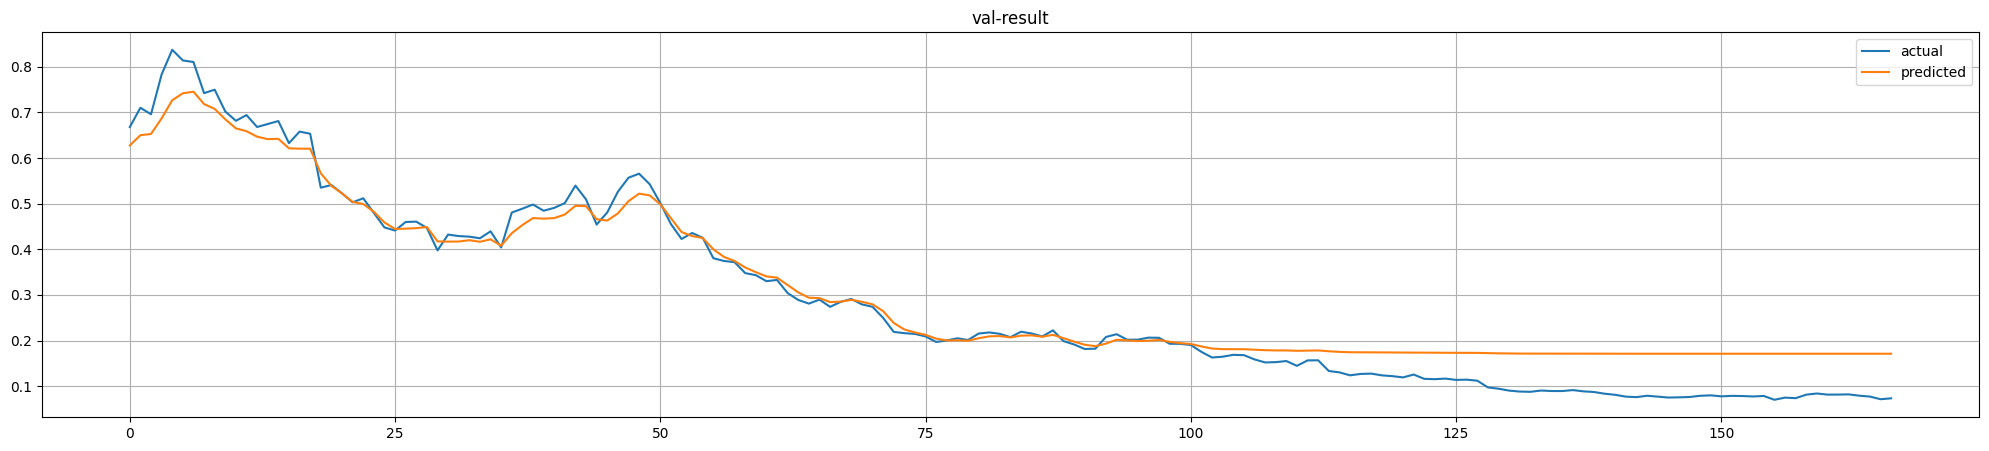

Epoch 1/80


2023-03-30 19:45:21.825731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 19:45:21.827631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 19:45:21.828870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

14/14 [==============================] - 4s 15ms/step - loss: 0.1598 - root_mean_squared_error: 0.3997 - mae: 0.3287
Epoch 2/80
14/14 [==============================] - 0s 16ms/step - loss: 0.0308 - root_mean_squared_error: 0.1755 - mae: 0.1505
Epoch 3/80
14/14 [==============================] - 0s 15ms/step - loss: 0.0197 - root_mean_squared_error: 0.1403 - mae: 0.1156
Epoch 4/80
14/14 [==============================] - 0s 14ms/step - loss: 0.0092 - root_mean_squared_error: 0.0960 - mae: 0.0791
Epoch 5/80
14/14 [==============================] - 0s 16ms/step - loss: 0.0057 - root_mean_squared_error: 0.0758 - mae: 0.0595
Epoch 6/80
14/14 [==============================] - 0s 14ms/step - loss: 0.0048 - root_mean_squared_error: 0.0691 - mae: 0.0510
Epoch 7/80
14/14 [==============================] - 0s 14ms/step - loss: 0.0047 - root_mean_squared_error: 0.0688 - mae: 0.0494
Epoch 8/80
14/14 [==============================] - 0s 14ms/step - loss: 0.0048 - root_mean_squared_error: 0.0693 -

2023-03-30 19:45:44.194877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 19:45:44.196526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 19:45:44.197822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 1s 5ms/step
Mean Absolute Percentage Error: inf
Mean Absolute Error: 0.03553072633871814
Root Mean Squared Error: 0.04169987095070001


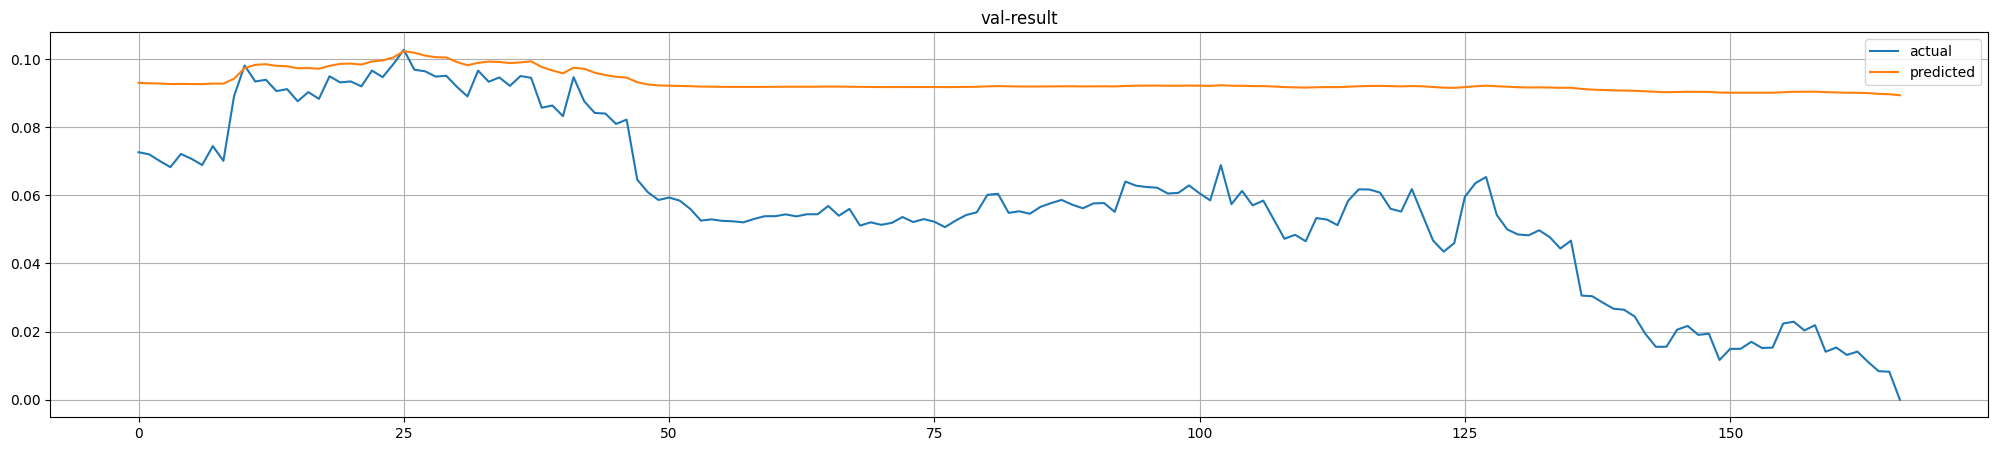

In [31]:
from tensorflow.keras import backend as K
import sklearn.metrics as metrics
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import TimeSeriesSplit


mape_lst = []
mae_lst = []
rmse_lst =[]

# Define the number of splits and the window size
n_splits = 5

# Initialize the time series split
tscv = TimeSeriesSplit(n_splits=n_splits)

# Perform rolling forward cross-validation
for train_idx, test_idx in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y_scaled[train_idx], y_scaled[test_idx]

    # Fit the model on the training data
    model = init_model()
    history = model.fit(X_train, y_train, epochs=80, batch_size=64)

    # Evaluate the model on the test data
    y_pred = model.predict(X_test)
    
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mape_lst.append(mape)
    print("Mean Absolute Percentage Error:", mape)
    
    mae, rmse = calculate_metrics(y_test, y_pred)
    mae_lst.append(mae)
    rmse_lst.append(rmse)
    print("Mean Absolute Error:", mae)
    print("Root Mean Squared Error:", rmse)
    
    plot_results(y_test, y_pred, 'val-result')
    
    


In [32]:
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'mae'])

In [33]:
#Predict model based on test data
y_pred = model.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred)
y_test = test_df['next_day_closing_price']

3/3 [==============================] - 0s 4ms/step


In [34]:
mape = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Absolute Percentage Error:", mape)

mae, rmse = calculate_metrics(y_test, y_pred)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
y_range = np.max(y_test) - np.min(y_test)

# Normalize RMSE
norm_rmse = rmse / y_range

print('Normalized RMSE:', norm_rmse)

Mean Absolute Percentage Error: 13.784123290758346
Mean Absolute Error: 419.85575112951807
Root Mean Squared Error: 554.952264054656
Normalized RMSE: 0.047083813479958804


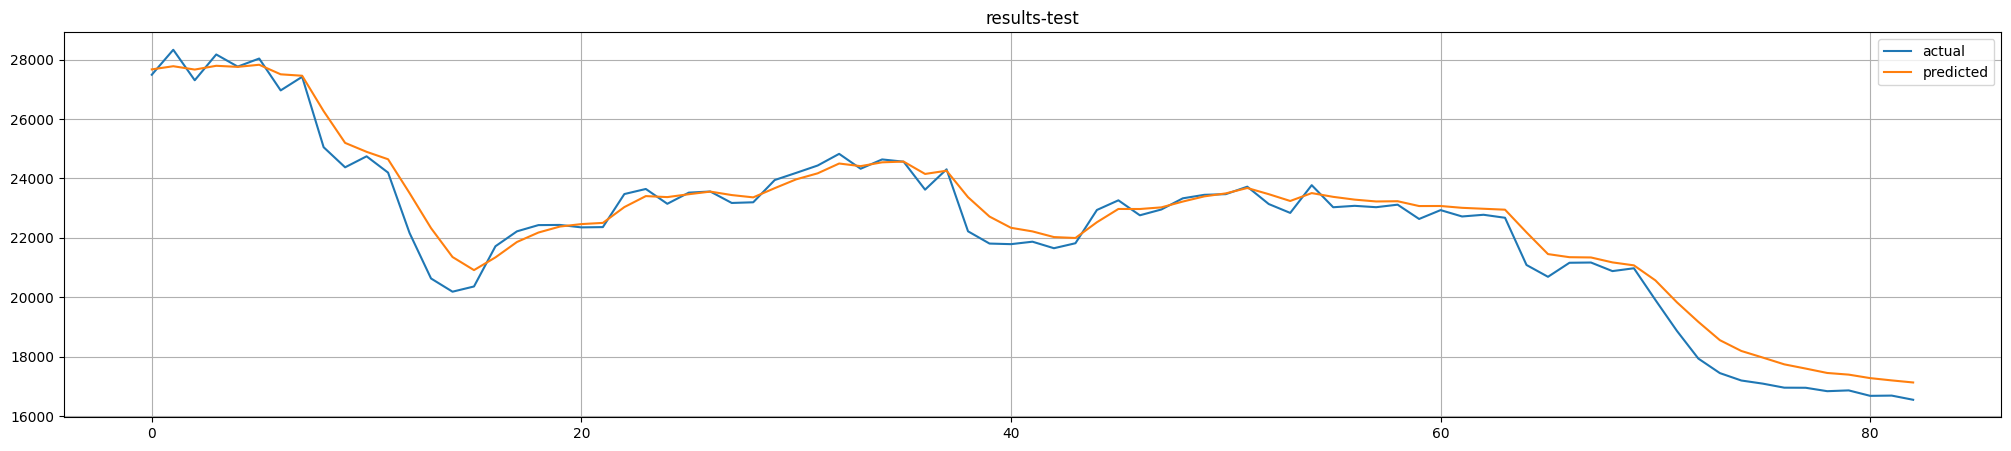

In [35]:
plot_results(y_test,y_pred,'results-test')

In [36]:
predicted_df = pd.DataFrame(y_pred, columns=['predicted_price'])
res_df = pd.concat([test_df, predicted_df], axis = 1) 
res_df.head()

,date,open,tema3 open,dema3 open,ema3 open,wma3 open,wma7 low,ema3 close,sma7 low,dema3 high,tema7 open,tema3 low,ema7 open,high,low,next_day_closing_price,predicted_price
0,2023-03-25,0.349892,0.343765,0.355428,0.355324,0.353856,0.359608,0.353276,0.36022,0.354646,0.25829,0.350497,0.361538,0.341772,0.352074,27493.285156,27673.556641
1,2023-03-24,0.363470,0.343765,0.355428,0.355324,0.353856,0.359608,0.353276,0.36022,0.354646,0.25829,0.350497,0.361538,0.351351,0.349478,28333.972656,27780.365234
2,2023-03-23,0.346884,0.343765,0.355428,0.355324,0.353856,0.359608,0.353276,0.36022,0.354646,0.25829,0.350497,0.361538,0.356832,0.351861,27307.437500,27667.490234
3,2023-03-22,0.360787,0.343765,0.355428,0.359079,0.357595,0.359608,0.349402,0.36022,0.354646,0.25829,0.350497,0.361538,0.358012,0.344861,28175.816406,27794.681641
4,2023-03-21,0.354453,0.343765,0.355428,0.357730,0.356279,0.359608,0.354676,0.36022,0.354646,0.25829,0.350497,0.361538,0.352172,0.356098,27767.236328,27758.308594


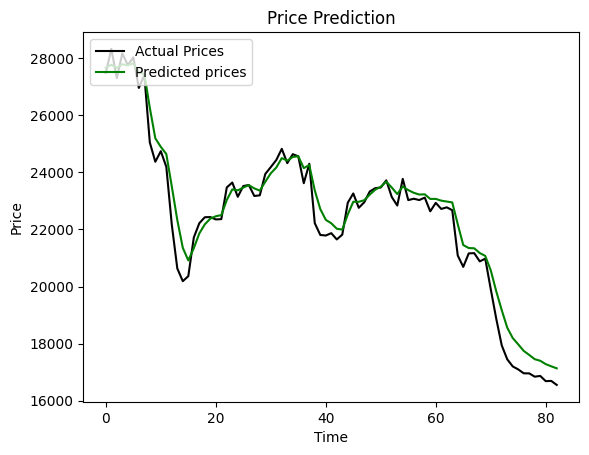

In [37]:
plt.plot(res_df['next_day_closing_price'], color="black", label="Actual Prices")
plt.plot(res_df['predicted_price'], color="green", label="Predicted prices")
plt.title("Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend(loc="upper left")
plt.show()

In [38]:
# To save or load the model uncomment this
from keras.models import load_model
# save the model 
model.save('../trained_model/is3107_crypto_model_30032023.h5')
# load the model
# model = load_model('./trained_model/is3107_crypto_model_30032023.h5')